# Imports

In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt

# Data

In [2]:
from IPython.display import clear_output

from djimaging.user.alpha.utils import database

indicator = 'calcium'
database.connect_dj(indicator=indicator)
clear_output()

In [22]:
exp_tab  = database.get_experiment_tab()
field_tab = database.get_field_tab()
roi_pos_tab = database.get_roi_pos_tab()

field_stack_pos_tab = database.get_field_stack_pos_tab()
rf_morph_tab, rf_tab, morph_tab, cells = database.get_rf_and_morph_tab(roi_kind='soma', quality_filter=True)
df_field_rfs, field_avg_dx, field_avg_dy = database.get_field_avg_offset()
df_field_rfs.head(3)

Found 1 RFs for {'experimenter': 'Ran', 'date': datetime.date(2018, 6, 10), 'exp_num': 1}
Found 2 RFs for {'experimenter': 'Ran', 'date': datetime.date(2020, 5, 10), 'exp_num': 1}
Found 2 RFs for {'experimenter': 'Ran', 'date': datetime.date(2020, 5, 10), 'exp_num': 2}
Found 2 RFs for {'experimenter': 'Ran', 'date': datetime.date(2020, 5, 11), 'exp_num': 1}
Found 2 RFs for {'experimenter': 'Ran', 'date': datetime.date(2020, 5, 11), 'exp_num': 2}
Found 2 RFs for {'experimenter': 'Ran', 'date': datetime.date(2020, 6, 7), 'exp_num': 1}
Found 2 RFs for {'experimenter': 'Ran', 'date': datetime.date(2020, 6, 8), 'exp_num': 1}
Found 2 RFs for {'experimenter': 'Ran', 'date': datetime.date(2020, 6, 8), 'exp_num': 2}
Found 2 RFs for {'experimenter': 'Ran', 'date': datetime.date(2020, 6, 21), 'exp_num': 1}
Found 3 RFs for {'experimenter': 'Ran', 'date': datetime.date(2020, 7, 8), 'exp_num': 1}
Found 2 RFs for {'experimenter': 'Ran', 'date': datetime.date(2020, 7, 13), 'exp_num': 1}
Found 2 RFs fo

experimenter   stim_name  raw_id    cond1  \
date       exp_num field                                             
2018-06-10 1       D1             Ran  noise_2500       1  control   
                   D2             Ran  noise_2500       1  control   
                   D3             Ran  noise_2500       1  control   

                          preprocess_id  dnoise_params_id  rf_glm_params_id  \
date       exp_num field                                                      
2018-06-10 1       D1                 1                 1                10   
                   D2                 1                 1                10   
                   D3                 1                 1                10   

                          split_rf_params_id  rf_contours_params_id  \
date       exp_num field                                              
2018-06-10 1       D1                      1                      1   
                   D2                      1                      1   
                   D3                      1                      1   

                          field_rf_dx_um  field_rf_dy_um  field_rf_d_um  
date       exp_num field                                                 
2018-06-10 1       D1            29.2784         7.05411        30.1162  
                   D2            54.2863        45.45800        70.8056  
                   D3            13.5319        22.08470        25.9007

# Plot

In [4]:
from alphaanalysis import plot as plota

plota.set_default_params(kind='paper')

In [5]:
FIGURE_FOLDER = './figures/'

## All cells

In [6]:
order = plota.get_order(indicator=indicator)
order

['n', 'd', 't']

In [7]:
keys = np.array(rf_morph_tab.fetch('KEY'), dtype=object)
groups = rf_morph_tab.fetch('group')
max_group = np.max(np.unique(groups, return_counts=True)[1])

In [8]:
blur_std, blur_npix, upsample_srf_scale = database.GLMContoursParams().fetch1(
    'blur_std', 'blur_npix', 'upsample_srf_scale')

n 6
d 4
t 6


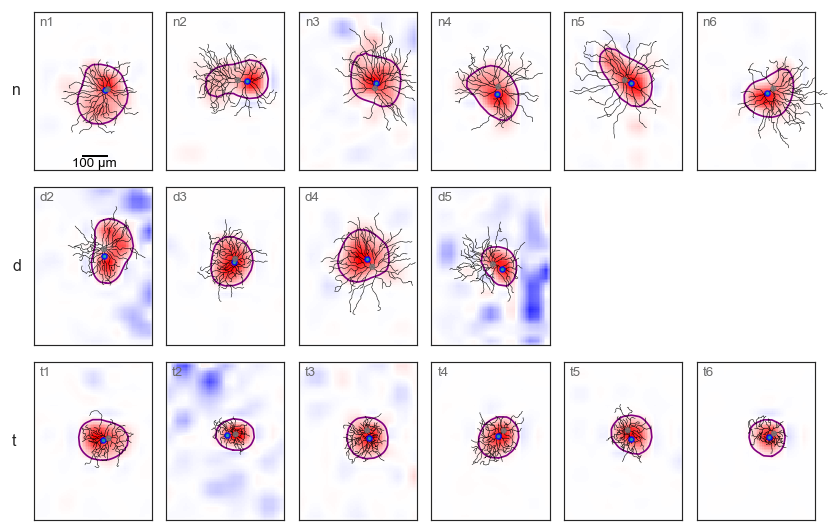

In [9]:
fig, axs = plt.subplots(len(order), max_group, figsize=(7, 4.5))

for ax_row, group in zip(axs, order):
    group_keys = keys[groups == group]
    cell_tags = np.array([(exp_tab & key).fetch1('cell_tag') for key in group_keys])

    sort_idxs = np.argsort(cell_tags)
    group_keys = group_keys[sort_idxs]
    cell_tags = cell_tags[sort_idxs]

    print(group, len(group_keys))

    plota.row_title(ax_row[0], group, pad=5)

    for ax, key, cell_tag in zip(ax_row, group_keys, cell_tags):
        plota.fetch_and_plot_srf_and_morph(
            key, 'soma', 'contour',
            rf_tab, morph_tab, roi_pos_tab, exp_tab, field_tab,
            blur_std=0, blur_npix=0, upsample_srf_scale=upsample_srf_scale,
            ax=ax, plot_center=False, plot_im=True, plot_outline=True, plot_morph=True, plot_roi=True,
            add_offset_rf=(-field_avg_dx.loc[(str(key['date']), key['exp_num'])],
                           -field_avg_dy.loc[(str(key['date']), key['exp_num'])]),
            fit_srf_xlim=True,
        )

        ax.text(0.05, 0.97, cell_tag, transform=ax.transAxes, verticalalignment='top', color='dimgray')

        #ax.axis('off')
        ax.set(xticks=[], yticks=[])

    for ax in ax_row[len(group_keys):]:
        ax.axis('off')

plt.tight_layout()

plota.plot_scale_bar(axs[0, 0], x0=-90, y0=-250, size=100, pad=-10, text='100 µm', orientation='h')

fig.savefig(os.path.join(FIGURE_FOLDER, f'all_soma_srfs.pdf'), bbox_inches='tight')

## Select example cells

In [10]:
cell_selection = [
    dict(date="2020-06-08", exp_num=1),
    dict(date="2020-05-11", exp_num=1),
]

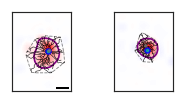

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(2.0, 0.9))

for ax, cell in zip(axs, cell_selection):
    key = (rf_tab & cell).fetch1('KEY')
    plota.fetch_and_plot_srf_and_morph(
        key, 'soma', 'contour',
        rf_tab, morph_tab, roi_pos_tab, exp_tab, field_tab,
        ax=ax, plot_center=False, plot_im=True, plot_outline=True, plot_morph=True, plot_roi=True,
        blur_std=0, blur_npix=0, upsample_srf_scale=upsample_srf_scale,
        hull_points=(morph_tab & cell).fetch1('hull_points'),
        add_offset_rf=(-field_avg_dx.loc[(str(key['date']), key['exp_num'])],
                       -field_avg_dy.loc[(str(key['date']), key['exp_num'])]),
        fit_srf_xlim=True,
    )
    ax.set(xticks=[], yticks=[])

plt.tight_layout()
plota.plot_scale_bar(axs[0], x0=60, y0=-280, size=100, pad=-10, text='', orientation='h')

fig.savefig(os.path.join(FIGURE_FOLDER, 'soma_rf_examples.pdf'), bbox_inches='tight', dpi=600)

# Locations of selected cells

In [25]:
df_cell_locations = morph_tab.proj('ventral_dorsal_pos', 'temporal_nasal_pos', 'group').fetch(format='frame')

df_cell_locations['has_soma_roi'] = False
df_cell_locations.loc[(morph_tab.proj() & rf_tab.proj()).fetch(format='frame').index, 'has_soma_roi'] = True

df_cell_locations['is_selected'] = False
df_cell_locations.loc[
    (morph_tab.proj() & rf_tab.proj() & cell_selection).fetch(format='frame').index, 'is_selected'] = True

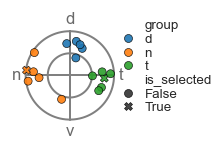

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.3))

plota.plot_cell_locations(
    df_cell_locations,
    indicator=indicator,
    markerby='is_selected',
    text=True,
    alpha=0.9,
    ax=ax
)
plt.tight_layout()
fig.savefig(os.path.join(FIGURE_FOLDER, f'cell_locations_{indicator}.pdf'), bbox_inches='tight')